In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

### LOADING DATA

In [3]:
train_data = pd.read_csv('../data/all_points_s2.csv')

In [4]:
train_data._data

/var/folders/l8/mx9jxmfs26g9mp3g0c91v78w0000gn/T/ipykernel_18198/2324421042.py:1: DeprecationWarning: DataFrame._data is deprecated and will be removed in a future version. Use public APIs instead.
  train_data._data


BlockManager
Items: Index(['B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
       'B9', 'landcover', 'polygon_idx', 'month'],
      dtype='object')
Axis 1: RangeIndex(start=0, stop=363, step=1)
NumpyBlock: slice(0, 12, 1), 12 x 363, dtype: float64
NumpyBlock: slice(13, 14, 1), 1 x 363, dtype: int64
NumpyBlock: slice(12, 16, 2), 2 x 363, dtype: object

In [5]:
train_data.head()

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,landcover,polygon_idx,month
0,0.404667,0.654667,0.532667,0.340667,0.446000,0.418667,0.639000,0.681000,0.596667,0.501333,0.634333,0.741333,urban,0,2024-01
1,0.348167,0.673500,0.598333,0.267667,0.340667,0.361500,0.547333,0.601500,0.644167,0.507167,0.607833,0.696833,urban,0,2024-02
2,0.388500,0.779000,0.668667,0.331000,0.396333,0.422333,0.661000,0.680500,0.736500,0.625500,0.725167,0.790333,urban,0,2024-03
3,0.433333,0.883667,0.783333,0.376667,0.488667,0.499000,0.704667,0.802000,0.829667,0.751333,0.898667,0.936333,urban,0,2024-04
4,0.425667,0.883000,0.724000,0.422667,0.465333,0.554333,0.788333,0.852667,0.797667,0.780333,0.930333,0.951667,urban,0,2024-05


### Processing

In [6]:
train_data= train_data.copy()
# find all unique values of training data names to use as classes
classes = sorted(train_data['landcover'].unique())
print(classes)

class_dict = dict(zip(classes, range(len(classes))))
train_data['class'] = train_data['landcover'].map(class_dict)

['bare', 'urban', 'vegetation', 'water']


In [7]:
def add_spectral_indices(df, bands):
    """
    Ajoute des indices spectraux (NDVI, NDWI, NBR, EVI) au DataFrame
    :param df: DataFrame pandas contenant les colonnes Sentinel (B2,B3,B4,B8,B11,B12)
    :param bands: dictionnaire de mapping { 'B2': 'blue', 'B3': 'green', 'B4': 'red', 'B8': 'nir', 'B11': 'swir1', 'B12': 'swir2'}
    :return: DataFrame avec colonnes supplémentaires
    """
    blue  = df[bands['B2']].astype(float)
    green = df[bands['B3']].astype(float)
    red   = df[bands['B4']].astype(float)
    nir   = df[bands['B8']].astype(float)
    swir1 = df[bands['B11']].astype(float)
    swir2 = df[bands['B12']].astype(float)

    # NDVI
    df['NDVI'] = (nir - red) / (nir + red + 1e-6)

    # NDWI (McFeeters)
    df['NDWI'] = (green - nir) / (green + nir + 1e-6)

    # NBR (Normalized Burn Ratio)
    df['NBR'] = (nir - swir2) / (nir + swir2 + 1e-6)

    # EVI (Enhanced Vegetation Index, simplifié)
    df['EVI'] = 2.5 * ( (nir - red) / (nir + 6*red - 7.5*blue + 1) )

    return df

In [8]:
# Ajouter les indices spectraux
compte_indices = add_spectral_indices(train_data, {
    'B2': 'B2', 'B3': 'B3', 'B4': 'B4',
    'B8': 'B8', 'B11': 'B11', 'B12': 'B12'
})

In [9]:
extraction_features_train= compte_indices.drop(columns=['month', 'landcover', 'polygon_idx'])

In [10]:
X = extraction_features_train.drop( columns=['class'])
y = extraction_features_train['class']

### Creating model

In [11]:
# Split sample to train and test
seeds = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seeds)

In [14]:
from sklearn.preprocessing import LabelEncoder

cat_cols = X_train.select_dtypes(include=['object']).columns

le = LabelEncoder()
for col in cat_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [15]:
rf_model= RandomForestClassifier(n_estimators=100, random_state=seeds)
rf_model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Saving model

In [16]:
from joblib import dump, load

# Sauvegarder le modèle
rf_model_file = "../model/rf_model.joblib"
dump(rf_model, rf_model_file)
print(f"Modèle sauvegardé dans {rf_model_file}")


Modèle sauvegardé dans ../model/rf_model.joblib


Prédictions uniques : [0 1 2 3]
Accuracy : 89.04%

Rapport de classification:
               precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.89      0.97      0.93        33
           2       1.00      0.83      0.91        18
           3       0.90      1.00      0.95         9

    accuracy                           0.89        73
   macro avg       0.88      0.87      0.88        73
weighted avg       0.89      0.89      0.89        73



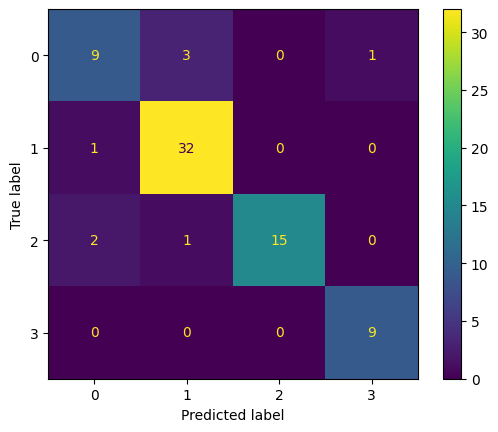

In [17]:
# Évaluer le modèle
y_pred = rf_model.predict(X_test)

print("Prédictions uniques :", np.unique(y_pred))
print("Accuracy : {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))

# Matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# Rapport détaillé
print("\nRapport de classification:\n", classification_report(y_test, y_pred))